In [67]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, AUC


In [68]:
SEED = 42
NUM_EPOCHS = 3
TARGET_LABEL = "dx"
BALANCE_LABEL = "dx"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

In [69]:
FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/bjzim-models/'  # Replace with your folder path

In [70]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

In [71]:
import os

log_dir = "./tensorboard_logs"
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

In [72]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [73]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Checking if validation/ test data are not augmented

In [74]:
# Überprüfung für validation_df
if any(validation_df['image_id'].str.startswith('aug_')):
    print("Warnung: Augmentierte Daten im Validierungsset gefunden.")

# Überprüfung für test_df
if any(test_df['image_id'].str.startswith('aug_')):
    print("Warnung: Augmentierte Daten im Testset gefunden.")


## Define Callbacks for Model

In [75]:
# EarlyStopping-Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrik, die überwacht wird
    patience=2,         # Anzahl der Epochen für patience angepasst
    verbose=1,           # Ausgabe-Steuerung
    restore_best_weights=True  # Die besten Gewichtungen wiederherstellen
)

In [76]:
# ReduceLROnPlateau-Callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metrik, die überwacht wird
    factor=0.1,          # Faktor, um die Lernrate zu reduzieren
    patience=5,          # Anzahl der Epochen ohne Verbesserung
    verbose=1,           # Ausgabe-Steuerung
    min_lr=1e-6          # Minimale Lernrate
)

## **Build Model:**

In [77]:
# Initialize the MobileNetV3Large model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Unfreeze some of the layers for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True


# Add custom layers on top
x = layers.Conv2D(128, (3, 3), activation='relu')(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)


# Create the full model
model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D")


## Parameter Grid: Data Preprocessing and Augmentation, Model

In [78]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import load_model
import os

# Beste Metrik initialisieren
best_val_recall = 0.0
best_params = None
best_model_path = "best_model_recall.h5"

# Bestehende Erkenntnisse laden
learning_rate = 0.01
batch_size = 128

# Definiere die Parameter für die Grid-Suche
param_grid = {
    'rotation_range': [0, 10, 20, 30, 45],
    'width_shift_range': [0.05, 0.1, 0.2],
    'height_shift_range': [0.05, 0.1, 0.2],
    'zoom_range': [0.05, 0.1, 0.2, 0.3],
    'horizontal_flip': [True, False],
    'vertical_flip': [True, False]
}


# Modell-Kompilierung (vor der Schleife, da die Lernrate konstant bleibt)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),  # Deine feste Lernrate
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

# Erstelle eine Liste aller Kombinationen der Hyperparameter
grid = ParameterGrid(param_grid)
total_iterations = len(grid)  # Gesamtanzahl der Iterationen
iteration = 1  # Aktuelle Iteration

# Durchlaufe jede Kombination der Hyperparameter
for params in grid:
    print(f"Training with params: {params}")
    print(f"Iteration {iteration} of {total_iterations}")
    
    # Definiere den TensorBoard-Log-Pfad für diese Hyperparameter-Kombination
#    log_dir = f"./tensorboard_logs/{params}"
#    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Erstelle einen neuen ImageDataGenerator mit den aktuellen Parametern
    datagen_train = ImageDataGenerator(
        rescale=1.0 / 255.0,
        preprocessing_function=preprocess_input,
        rotation_range=params['rotation_range'],
        width_shift_range=params['width_shift_range'],
        height_shift_range=params['height_shift_range'],
        zoom_range=params['zoom_range'],
        horizontal_flip=params['horizontal_flip'],
        vertical_flip=params['vertical_flip'],
        fill_mode='nearest'
    )
    
    train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=batch_size
    )
    
    datagen_validation = ImageDataGenerator(
        rescale=1.0 / 255.0, #see above
        preprocessing_function=preprocess_input
    )

    validation_generator = datagen_validation.flow_from_dataframe(
        dataframe=validation_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=batch_size
    )

    # Trainiere das Modell mit den aktuellen Data Augmentation Parametern
    # (Der Rest des Trainingscodes bleibt gleich)
    # Train the model

    history = model.fit(
        train_data_generator,
        epochs=NUM_EPOCHS,
        verbose=1,                      # Adjust verbosity level
        batch_size=batch_size,                # Set the batch size, default is 32, can be increased to speed up training, but memory consumption increases
        callbacks=[early_stopping, reduce_lr],                 # removed tensorboard_callback
        validation_split=0.0,           # not needed as we use a validation data generator
        validation_data=validation_generator,
        shuffle=True,                   # Shuffle the training data before each epoch
        sample_weight=None,             # Set the weights for the train data set !
        class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
        initial_epoch=0,                # Use this to continue training from a specific epoch
        steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
        validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
        validation_batch_size=None,     # Set the batch size for validation, default is batch_size
        validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
        max_queue_size=10,              # Set the max size for the generator queue
        workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
        use_multiprocessing=True       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
    )

    # Überprüfe, ob dieses Modell besser ist als das bisher beste
    final_val_recall = history.history['val_recall'][-1]
    if final_val_recall > best_val_recall:
        print(f"New best model found! val_recall: {final_val_recall}")
        best_val_recall = final_val_recall
        best_params = params

        # Speichere das beste Modell
        model.save(best_model_path)

    iteration += 1  # Aktualisiere die Iterationszählung



Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 0, 'vertical_flip': True, 'width_shift_range': 0.05, 'zoom_range': 0.05}
Iteration 1 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3


2023-10-05 08:43:30.227221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - ETA: 0s - loss: 2.1826 - accuracy: 0.1532 - precision: 0.2068 - recall: 0.0093 - auc: 0.5358

2023-10-05 08:47:10.034782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 292s 5s/step - loss: 2.1826 - accuracy: 0.1532 - precision: 0.2068 - recall: 0.0093 - auc: 0.5358 - val_loss: 27110383616.0000 - val_accuracy: 0.0145 - val_precision: 0.0145 - val_recall: 0.0145 - val_auc: 0.4251 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 91s 2s/step - loss: 1.9360 - accuracy: 0.2481 - precision: 0.3511 - recall: 0.0188 - auc: 0.6927 - val_loss: 5420455424.0000 - val_accuracy: 0.0509 - val_precision: 0.0509 - val_recall: 0.0509 - val_auc: 0.4464 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 94s 2s/step - loss: 1.8643 - accuracy: 0.2536 - precision: 0.3355 - recall: 0.0194 - auc: 0.7095 - val_loss: 249621536.0000 - val_accuracy: 0.0145 - val_precision: 0.0145 - val_recall: 0.0145 - val_auc: 0.4251 - lr: 0.0100
New best model found! val_recall: 0.014478283002972603


/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 0, 'vertical_flip': True, 'width_shift_range': 0.05, 'zoom_range': 0.1}
Iteration 2 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 93s 2s/step - loss: 1.8173 - accuracy: 0.2867 - precision: 0.3867 - recall: 0.0244 - auc: 0.7229 - val_loss: 1883975.5000 - val_accuracy: 0.6695 - val_precision: 0.6695 - val_recall: 0.6695 - val_auc: 0.8072 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 102s 2s/step - loss: 1.7732 - accuracy: 0.3185 - precision: 0.4314 - recall: 0.0335 - auc: 0.7345 - val_loss: 4296791.5000 - val_accuracy: 0.1108 - val_precision: 0.1108 - val_recall: 0.1108 - val_auc: 0.4813 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 100s 2s/step - loss: 1.7427 - accuracy: 0.3187 - precision: 0.4482 - recall: 0.0535 - auc: 0.7411

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 0, 'vertical_flip': True, 'width_shift_range': 0.05, 'zoom_range': 0.2}
Iteration 3 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 96s 2s/step - loss: 1.8029 - accuracy: 0.2789 - precision: 0.3542 - recall: 0.0226 - auc: 0.7156 - val_loss: 537227264.0000 - val_accuracy: 0.1108 - val_precision: 0.1108 - val_recall: 0.1108 - val_auc: 0.4813 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 92s 2s/step - loss: 1.8058 - accuracy: 0.2791 - precision: 0.3528 - recall: 0.0219 - auc: 0.7192 - val_loss: 240360624.0000 - val_accuracy: 0.1098 - val_precision: 0.1098 - val_recall: 0.1098 - val_auc: 0.4807 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 108s 3s/step - loss: 1.7534 - accuracy: 0.3042 - precision: 0.3879 - recall: 0.0207 - auc: 0.7

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 0, 'vertical_flip': True, 'width_shift_range': 0.05, 'zoom_range': 0.3}
Iteration 4 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 108s 3s/step - loss: 1.7411 - accuracy: 0.3158 - precision: 0.4212 - recall: 0.0325 - auc: 0.7412 - val_loss: 62725048.0000 - val_accuracy: 0.0330 - val_precision: 0.0330 - val_recall: 0.0330 - val_auc: 0.4359 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 104s 2s/step - loss: 1.6644 - accuracy: 0.3516 - precision: 0.4681 - recall: 0.0683 - auc: 0.7650 - val_loss: 1681442560.0000 - val_accuracy: 0.0330 - val_precision: 0.0330 - val_recall: 0.0330 - val_auc: 0.4359 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 101s 2s/step - loss: 1.6192 - accuracy: 0.3611 - precision: 0.5224 - recall: 0.0866 - auc: 0

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 20, 'vertical_flip': True, 'width_shift_range': 0.1, 'zoom_range': 0.3}
Iteration 56 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 107s 3s/step - loss: 0.7392 - accuracy: 0.7220 - precision: 0.7951 - recall: 0.6423 - auc: 0.9537 - val_loss: 161.2234 - val_accuracy: 0.6680 - val_precision: 0.6680 - val_recall: 0.6680 - val_auc: 0.8068 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 103s 2s/step - loss: 0.7452 - accuracy: 0.7228 - precision: 0.7898 - recall: 0.6368 - auc: 0.9530 - val_loss: 125.1867 - val_accuracy: 0.6680 - val_precision: 0.6680 - val_recall: 0.6680 - val_auc: 0.8063 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 105s 2s/step - loss: 0.7356 - accuracy: 0.7270 - precision: 0.7976 - recall: 0.6484 - auc: 0.9540 - val

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 20, 'vertical_flip': True, 'width_shift_range': 0.2, 'zoom_range': 0.1}
Iteration 58 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 107s 3s/step - loss: 0.7975 - accuracy: 0.6967 - precision: 0.7774 - recall: 0.6020 - auc: 0.9467 - val_loss: 140.3277 - val_accuracy: 0.6695 - val_precision: 0.6695 - val_recall: 0.6695 - val_auc: 0.8072 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 102s 2s/step - loss: 0.6942 - accuracy: 0.7403 - precision: 0.8141 - recall: 0.6516 - auc: 0.9595 - val_loss: 161.8582 - val_accuracy: 0.6690 - val_precision: 0.6690 - val_recall: 0.6690 - val_auc: 0.8069 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 104s 2s/step - loss: 0.7549 - accuracy: 0.7156 - precision: 0.7874 - recall: 0.6299 - auc: 0.9518 - val

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': True, 'rotation_range': 20, 'vertical_flip': False, 'width_shift_range': 0.05, 'zoom_range': 0.05}
Iteration 61 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 101s 2s/step - loss: 0.6043 - accuracy: 0.7776 - precision: 0.8336 - recall: 0.7091 - auc: 0.9689 - val_loss: 85.7032 - val_accuracy: 0.6690 - val_precision: 0.6690 - val_recall: 0.6690 - val_auc: 0.8069 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 102s 2s/step - loss: 0.6694 - accuracy: 0.7466 - precision: 0.8090 - recall: 0.6739 - auc: 0.9619 - val_loss: 94.4428 - val_accuracy: 0.6695 - val_precision: 0.6693 - val_recall: 0.6690 - val_auc: 0.8071 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 102s 2s/step - loss: 0.6130 - accuracy: 0.7723 - precision: 0.8286 - recall: 0.7121 - auc: 0.9678 - va

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': False, 'rotation_range': 20, 'vertical_flip': False, 'width_shift_range': 0.1, 'zoom_range': 0.3}
Iteration 188 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 85s 2s/step - loss: 0.1248 - accuracy: 0.9610 - precision: 0.9630 - recall: 0.9570 - auc: 0.9969 - val_loss: 6.0305 - val_accuracy: 0.6685 - val_precision: 0.6683 - val_recall: 0.6680 - val_auc: 0.8150 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 85s 2s/step - loss: 0.2710 - accuracy: 0.9064 - precision: 0.9162 - recall: 0.8992 - auc: 0.9915 - val_loss: 16.8244 - val_accuracy: 0.6690 - val_precision: 0.6690 - val_recall: 0.6690 - val_auc: 0.8092 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 87s 2s/step - loss: 0.1968 - accuracy: 0.9334 - precision: 0.9410 - recall: 0.9254 - auc: 0.9953 - val_lo

/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training with params: {'height_shift_range': 0.05, 'horizontal_flip': False, 'rotation_range': 30, 'vertical_flip': True, 'width_shift_range': 0.05, 'zoom_range': 0.05}
Iteration 193 of 720
Found 5256 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Epoch 1/3
42/42 [==============================] - 85s 2s/step - loss: 0.1233 - accuracy: 0.9570 - precision: 0.9619 - recall: 0.9522 - auc: 0.9979 - val_loss: 4.5748 - val_accuracy: 0.6630 - val_precision: 0.6643 - val_recall: 0.6590 - val_auc: 0.8362 - lr: 0.0100
Epoch 2/3
42/42 [==============================] - 85s 2s/step - loss: 0.0921 - accuracy: 0.9677 - precision: 0.9720 - recall: 0.9637 - auc: 0.9990 - val_loss: 5.3058 - val_accuracy: 0.6735 - val_precision: 0.6809 - val_recall: 0.6700 - val_auc: 0.8299 - lr: 0.0100
Epoch 3/3
42/42 [==============================] - 85s 2s/step - loss: 0.0871 - accuracy: 0.9717 - precision: 0.9744 - recall: 0.9699 - auc: 0.9990 - val_lo

Best val_recall: 0.6779830455780029
Best params: {'height_shift_range': 0.05, 'horizontal_flip': False, 'rotation_range': 20, 'vertical_flip': False, 'width_shift_range': 0.2, 'zoom_range': 0.3}
Best model path: best_model_recall.h5
Best model name: MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D
Best model optimizer: <keras.src.optimizers.legacy.adam.Adam object at 0x680ee09d0>
Best model metrics: ['loss', 'accuracy', 'precision', 'recall', 'auc']


2023-10-07 20:33:52.292639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 69s 3s/step - loss: 5.4312 - accuracy: 0.6790 - precision: 0.6810 - recall: 0.6780 - auc: 0.8370
Best model loss & metrics: [5.431225776672363, 0.6789815425872803, 0.6810431480407715, 0.6779830455780029, 0.8369778394699097]
Model: "MobilneNetV3Large_pretrained-weights_fixed-layers_custom-conv2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       

2023-10-07 20:35:02.726123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 53s 2s/step


NameError: name 'target_names' is not defined

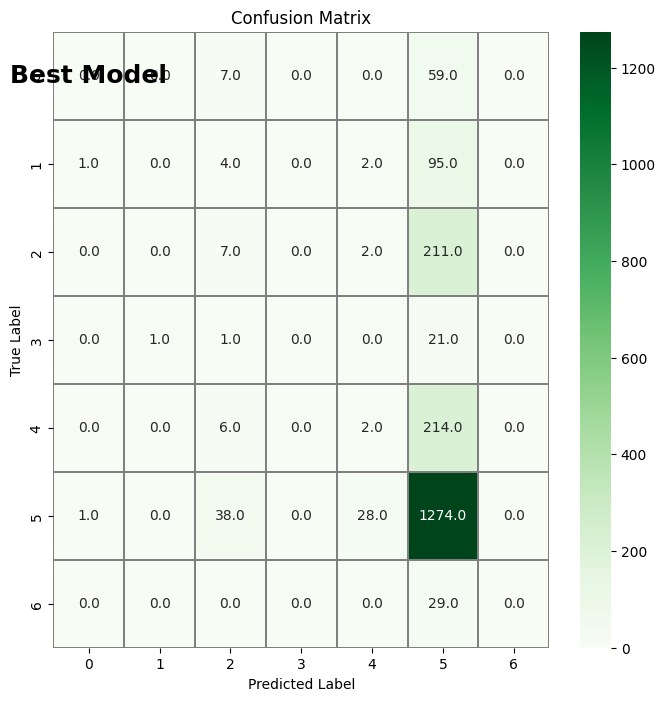

In [79]:
# Lade das beste Modell
best_model = load_model(best_model_path)


print(f"Best val_recall: {best_val_recall}")
print(f"Best params: {best_params}")
print(f"Best model path: {best_model_path}")
print(f"Best model name: {best_model.name}")
print(f"Best model optimizer: {best_model.optimizer}")
print(f"Best model metrics: {best_model.metrics_names}")
print(f"Best model loss & metrics: {best_model.evaluate(validation_generator)}")
print(f"Best model summary: {best_model.summary()}")
print(f"Best model layers: {best_model.layers}")
best_model_weights = best_model.get_weights()
print(f"Best model weights: {best_model_weights}")
print(f"Best model history: {best_model.history}")

# sns heatmap for confusion matrix of best model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict the values from the validation dataset
Y_pred = best_model.predict(validation_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = validation_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# print classification report 
print('Classification Report')
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print(classification_report(validation_generator.classes, Y_pred_classes, target_names=target_names))



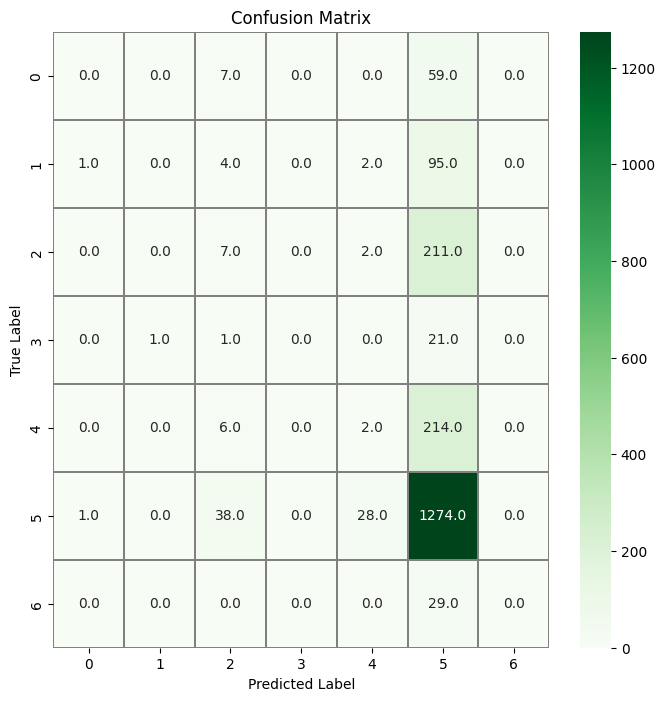

In [81]:
# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
#subtitle what is swhon in confusion matrix
plt.text(0.5, 0.5, "", horizontalalignment='center', verticalalignment='center', fontsize=18, fontweight='bold')
plt.show()

In [86]:
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

#plot roc-auc curve for best model
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(np.array(validation_generator.classes)[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(len(target_names)):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i], color='green')
    plt.plot([0, 1], [0, 1], 'k--', color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic for ' + target_names[i])
    plt.legend(loc="lower right")
    plt.show()



# plot precision-recall curve for each class and iso-f1 curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

# For each class
precision = dict()
recall = dict()
f1 = dict()
average_precision = dict()
for i in range(len(target_names)):
    precision[i], recall[i], _ = precision_recall_curve(validation_generator.classes[:, i], Y_pred[:, i])
    average_precision[i] = average_precision_score(validation_generator.classes[:, i], Y_pred[:, i])
    f1[i] = f1_score(validation_generator.classes[:, i], Y_pred_classes[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(validation_generator.classes.ravel(), Y_pred.ravel())
average_precision["micro"] = average_precision_score(validation_generator.classes, Y_pred, average="micro")
f1["micro"] = f1_score(validation_generator.classes, Y_pred_classes, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
print('Average F1 score, micro-averaged over all classes: {0:0.2f}'.format(f1["micro"]))
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))
plt.show()



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [83]:
# plot all grid params against val_recall, val_precision, val_accuracy, val_auc, val_loss,f1
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a dataframe from the grid search results
df_grid_aug = pd.DataFrame(grid)

# Add the validation metrics to the dataframe
df_grid_aug['val_recall'] = history.history['val_recall']
df_grid_aug['val_precision'] = history.history['val_precision']
df_grid_aug['val_accuracy'] = history.history['val_accuracy']
df_grid_aug['val_auc'] = history.history['val_auc']
df_grid_aug['val_loss'] = history.history['val_loss']

# calculate the f1 score for the validation data as a metric and add it to the dataframe
df_grid_aug['val_f1'] = 2 * (df_grid_aug['val_precision'] * df_grid_aug['val_recall']) / (df_grid_aug['val_precision'] + df_grid_aug['val_recall'])

#show the dataframe in better optical order and sortable with jupyter ipython format, bad values in red good in green
from IPython.display import display
def color_negative_red(val):
    color = 'red' if val < 0.5 else 'green'
    return 'color: %s' % color

df_grid_aug = df_grid_aug.style.applymap(color_negative_red, subset=['val_recall', 'val_precision', 'val_accuracy', 'val_auc', 'val_loss', 'val_f1'])
display(df_grid_aug)

ValueError: Length of values (3) does not match length of index (720)

In [89]:
df_grid_aug.head()

,height_shift_range,horizontal_flip,rotation_range,vertical_flip,width_shift_range,zoom_range
0,0.05,True,0,True,0.05,0.05
1,0.05,True,0,True,0.05,0.10
2,0.05,True,0,True,0.05,0.20
3,0.05,True,0,True,0.05,0.30
4,0.05,True,0,True,0.10,0.05


In [ ]:
df_grid_aug = df_grid_aug[['rotation_range', 'width_shift_range', 'height_shift_range', 'zoom_range', 'horizontal_flip', 'vertical_flip', 'val_recall', 'val_precision', 'val_accuracy', 'val_auc', 'val_loss', 'val_f1']]
df_grid_aug.sort_values(by=['val_f1'], ascending=False, inplace=True)
print(df_grid_aug.head(20))

In [ ]:
#export the dataframe to csv
df_grid_aug.to_csv(FILEPATH_OUTPUT+"df_grid_aug.csv", index=False)

In [ ]:
#Define df_grid as df_grid_aug
df_grid = df_grid_aug

# Plot all validation metrics for each parameter combination in one figure grid of 3x2
# Set the figure size
plt.figure(figsize=(15, 10))

# Lineplot the validation recall and train recall
plt.subplot(2, 3, 1)
sns.lineplot(data=df_grid, x='rotation_range', y='val_recall', label='val_recall')
sns.lineplot(data=df_grid, x='rotation_range', y='recall', label='train_recall')
plt.title('Recall')
plt.xlabel('rotation_range')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Lineplot the validation precision and train precision
plt.subplot(2, 3, 2)
sns.lineplot(data=df_grid, x='rotation_range', y='val_precision', label='val_precision')
sns.lineplot(data=df_grid, x='rotation_range', y='precision', label='train_precision')
plt.title('Precision')
plt.xlabel('rotation_range')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Lineplot the validation accuracy and train accuracy
plt.subplot(2, 3, 3)
sns.lineplot(data=df_grid, x='rotation_range', y='val_accuracy', label='val_accuracy')
sns.lineplot(data=df_grid, x='rotation_range', y='accuracy', label='train_accuracy')
plt.title('Accuracy')
plt.xlabel('rotation_range')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Lineplot the validation auc and train auc
plt.subplot(2, 3, 4)
sns.lineplot(data=df_grid, x='rotation_range', y='val_auc', label='val_auc')
sns.lineplot(data=df_grid, x='rotation_range', y='auc', label='train_auc')
plt.title('AUC')
plt.xlabel('rotation_range')
plt.ylabel('AUC')
plt.legend(loc='upper left')

# Lineplot the validation loss and train loss
plt.subplot(2, 3, 5)
sns.lineplot(data=df_grid, x='rotation_range', y='val_loss', label='val_loss')
sns.lineplot(data=df_grid, x='rotation_range', y='loss', label='train_loss')
plt.title('Loss')
plt.xlabel('rotation_range')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Lineplot the validation f1 and train f1
plt.subplot(2, 3, 6)
sns.lineplot(data=df_grid, x='rotation_range', y='val_f1', label='val_f1')
sns.lineplot(data=df_grid, x='rotation_range', y='f1', label='train_f1')
plt.title('F1')
plt.xlabel('rotation_range')
plt.ylabel('F1')
plt.legend(loc='upper left')

#add the fixed learning rate to the grid title and batch size and Model technique
plt.suptitle(f"Learning rate: {learning_rate}, batch size: {batch_size}, MobilNetV3Large_pretrained-weights_Partially_fixed-layers_custom-conv2D")


# Adjust the layout
plt.tight_layout()

plt.show()






In [ ]:
# show which grid params are the best for val_recall, val_precision, val_accuracy, val_auc, val_loss, f1
# Sort the dataframe by the validation recall
df_grid.sort_values(by='val_recall', ascending=False, inplace=True)

# Print the top 5 rows
print(df_grid.head())

# Sort the dataframe by the validation precision
df_grid.sort_values(by='val_precision', ascending=False, inplace=True)

# Print the top 5 rows
print(df_grid.head())

# Sort the dataframe by the validation accuracy
df_grid.sort_values(by='val_accuracy', ascending=False, inplace=True)

# Print the top 5 rows
print(df_grid.head())

# Sort the dataframe by the validation auc
df_grid.sort_values(by='val_auc', ascending=False, inplace=True)

# Print the top 5 rows
print(df_grid.head())

# Sort the dataframe by the validation loss
df_grid.sort_values(by='val_loss', ascending=True, inplace=True)

# Print the top 5 rows
print(df_grid.head())

# Sort the dataframe by the validation f1
df_grid.sort_values(by='val_f1', ascending=False, inplace=True)

# Print the top 5 rows
print(df_grid.head())



In [ ]:
#scatterplot val_AUC and val_recall for all grid params from df_grid with a for loop
# Set the figure size
plt.figure(figsize=(15, 10))

# Scatterplot the validation AUC and validation recall
plt.subplot(2, 3, 1)
sns.scatterplot(data=df_grid, x='val_auc', y='val_recall', hue='rotation_range')
plt.title('AUC vs. Recall')
plt.xlabel('AUC')
plt.ylabel('Recall')
plt.legend(loc='upper left')

# Scatterplot the validation AUC and validation precision
plt.subplot(2, 3, 2)
sns.scatterplot(data=df_grid, x='val_auc', y='val_precision', hue='rotation_range')
plt.title('AUC vs. Precision')
plt.xlabel('AUC')
plt.ylabel('Precision')
plt.legend(loc='upper left')

# Scatterplot the validation AUC and validation accuracy
plt.subplot(2, 3, 3)

sns.scatterplot(data=df_grid, x='val_auc', y='val_accuracy', hue='rotation_range')
plt.title('AUC vs. Accuracy')
plt.xlabel('AUC')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Scatterplot the validation AUC and validation loss
plt.subplot(2, 3, 4)
sns.scatterplot(data=df_grid, x='val_auc', y='val_loss', hue='rotation_range')
plt.title('AUC vs. Loss')
plt.xlabel('AUC')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Scatterplot the validation AUC and validation f1
plt.subplot(2, 3, 5)
sns.scatterplot(data=df_grid, x='val_auc', y='val_f1', hue='rotation_range')
plt.title('AUC vs. F1')
plt.xlabel('AUC')
plt.ylabel('F1')
plt.legend(loc='upper left')

# empty subplot
plt.subplot(2, 3, 6)
plt.axis('off')

# Add the fixed learning rate to the grid title and batch size and Model technique
plt.suptitle(f"Learning rate: {learning_rate}, batch size: {batch_size}, MobilNetV3Large")


# Adjust the layout
plt.tight_layout()

plt.show()


In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"{FILEPATH_OUTPUT}model_bjzim_MobileNetV3Large{timestamp}.h5"
model.save(model_path)



/Users/bjz/neueFische/capstone/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
